<a href="https://colab.research.google.com/github/ddvika/Data-Science-School-2020/blob/main/Part_2_Parallel_calcuation_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Занятие 2. Часть 2. Распараллеливание процессов на примере numba и joblib**
#### 01.12.2020

**Преподаватель: Виктория Дочкина**

Ссылка на колаб: https://colab.research.google.com/drive/19BH3ZlUzph5WYs_A1VtZSejXbGOmy_Vw?usp=sharing

### **План занятия:**
1. **Numba:** как писать код с for-циклами, за который не стыдно
    1. Краткое введение в `jit`-компиляцию: почему это работает. 
    2. `@numba.jit`. Директива `nopython`, её ограничения.
    3. Директива `parallel` и `numba.prange`: автоматическое распараллеливание кода.

2. **joblib:** как распараллеливать код на `Python`
    1. `Parallel`, `delayed`: пишем свой `map-reduce`
    2. `Memory`: автоматическая мемоизация

# Введение

В первой части руководства рассматривается [`numba`](http://numba.pydata.org/) это [`jit`-компилятор](https://en.wikipedia.org/wiki/Just-in-time_compilation) `Python`, переводящий функции на `Python` и `numpy` в байт-код. Прирост производительности при этом обеспечивается за счёт того, что интерпретатору больше не нужно выполнять тело функции построчно, проверять, на что указывает каждое имя в коде и т.д.

Во второй части руководства идёт речь  о `joblib` — библиотеке для максимально удобного написания `map-reduce` кода и мемоизации.

При написании руководства акцент был сделан на простоту в использовании и выразительность. Низкоуровневые детали происходящего, по возможности, опущены: заинтересованный читатель может ознакомиться с ними самостоятельно. Многие советы приобретают актуальность только при работе в многопроцессорной среде, но именно в таких условиях чаще всего происходит работа аналитика. Более продвинутые методы оптимизации — в духе `CPython`, — а также альтернативные  интерпретаторы — в духе `PyPy`, `Jython` и `Iron Python` — не рассмотрены сознательно, т.к. чаще всего не поддерживают основные библиотеки для `data science`.


# Numba: `jit`-компиляция

Особенности `numba` можно резюмировать следующим списком:
* Работает со стандартным интерпретатором `Python`.
* Несмотря на то, что это компилятор, явным образом указывать типы ненужно: они выводятся автоматически.
* Тесная интеграция с `numpy`: поддерживается [почти весь функционал](http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html).
* Не поддерживается `scipy`, `pandas`. В частности, это ограничивает использование `numba` в  статистике.
* Работает в многопоточной, многопроцессорной и распределённой среде, а также на `GPU`.

При этом `numba` не является:
* Заменой стандартного интерпретатора `Python` в отличие от `PyPy`, `Jython` и т.д.
* Транслятором кода на `Python` в `C/C++`

Функционал `numba` реализован в виде декораторов. Ниже рассмотрены основные из них

## `@numba.jit(nopython = True)`

`jit`-компиляция работает эффективнее всего, если функция, кроме вызова библиотек, использует только базовые конструкции языка в духе циклов и простейших элементов стандартной библиотеки. В противном случае `numba` генерирует код, который обращается к [`Python C API`](https://docs.python.org/2/c-api/index.html), чтобы обрабатывать все переменные как универсальные питоновские объекты — такой режим компиляции называется **объектным** (object mode). 

Декоратор `@numba.jit` по умолчанию сам решает, переходить ли в объектный режим или нет. Директива `nopython=True` заставляет его выбрасывать исключение, если перехода в объектный режим нельзя избежать. **Если не указать `nopython=True`, то прирост производительности гарантировать нельзя.**

Возьмём простую функцию с занятия про профилировщики и ускорим её с помощью декоратора `njit` или `numba.jit(nopython=True)`

In [1]:
from typing import Any, List
import numba
import numpy as np
import scipy.stats as sps

In [2]:
from math import sqrt
def f_pure_python(n):
    s = 0.
    for i in range(n):
        s += sqrt(i)
    return s

In [3]:
from numba import njit

@njit
def f(n):
    s = 0.
    for i in range(n):
        s += sqrt(i)
    return s

In [4]:
%timeit f_pure_python(200)
%timeit f(200)

100000 loops, best of 3: 14.7 µs per loop
The slowest run took 279984.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 622 ns per loop


Следующий пример

Пусть требуется написать функцию, складывающую два Numpy массива покомпонентно

In [5]:
def naive_sum(x, y):
    ans = np.empty_like(x)
    for i in range(len(x)):
        ans[i] = x[i] + y[i]
    return ans 

In [6]:
from numba import njit

@njit
def naive_sum_jit(x, y):
    ans = np.empty_like(x)
    for i in range(len(x)):
        ans[i] = x[i] + y[i]
    return ans 

In [7]:
x = np.ones((100,))
y = np.ones((100,))

In [8]:
%timeit naive_sum(x, y)
%timeit naive_sum_jit(x, y)

10000 loops, best of 3: 41.7 µs per loop
The slowest run took 167220.55 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 781 ns per loop


**Еще пример для выполнения:**

Допустим у Вас есть матрица 10x10. Необходимо Посчитать след матрицы (слкд матрицы - сумма ее диагональных элементов) и затем прибавить полученное значение к кажому элементу матрицы


In [ ]:
from numba import jit
import numpy as np

x = np.arange(100).reshape(10, 10)

print(x)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [ ]:
# TODO
def calc_trace(a):


In [ ]:
# TODO
@jit(nopython=True) #эквивалентно @njit
def calc_trace_jit(a):

In [ ]:
%timeit calc_trace(x)
%timeit calc_trace_jit(x)

А теперь попробуем применить @njit на Pandas Dataframe. Напишем две функции - одну без декоратора, пример обычноц операции в Python, вторую - с декоратором @njit и сравним их

**Задание:**

Создайте объект типа Pandas Dataframe (используйте pd.DataFrame.from_dict()), затем возведите полученные значения в степень 3 и посчитайте попарную ковариацию столбцов (dataframe.cov())

In [10]:
from numba import jit
import pandas as pd

x = {'a': [1, 2, 3], 'b': [20, 30, 40]}

In [11]:
# TODO try pure pandas
def use_pandas(x)

In [ ]:
%timeit use_pandas(x)

In [ ]:
# TODO try @njit

In [ ]:
# TODO try @njit
@njit
def use_pandas_jit(a):


In [ ]:
%timeit use_pandas_jit(x)

In [ ]:
# TODO try @jit

Как видим Numba не понимает что такое Pandas Dataframe и не обрабатывает код


Работу `numba` также наглядно иллюстрирует пример вычисления медианы средних Уолша -- медианы массива полусумм объектов выборки. Это устойчивая к выбросам статистика, которая по этому параметру -- т.н. _робастности_ -- располагается между  выборочной медианой (очень устойчива) и выборочным средним (очень неустойчиво). 

1. Наивная реализация на чистом Python

In [ ]:
import numba
import numpy as np

def walsh_median_pure_python(sample):
    walsh_averages = []
    n = len(sample)
    for i in range(n):
        for j in range(i + 1, n):
            walsh_averages.append((sample[i] + sample[j]) / 2)
    walsh_averages = sorted(walsh_averages)
    if n % 2 == 0:
        return 0.5 * (walsh_averages[(n - 1) // 2] + walsh_averages[n // 2])
    return walsh_averages[n // 2]

2. Тот же код, но с декоратором `@numba.jit`

In [ ]:
@numba.jit(nopython=True) #эквивалентно @njit
def walsh_median_jit(sample):
    walsh_averages = []
    n = len(sample)
    for i in range(n):
        for j in range(i + 1, n):
            walsh_averages.append((sample[i] + sample[j]) / 2)
    walsh_averages = sorted(walsh_averages)
    if n % 2 == 0:
        return 0.5 * (walsh_averages[(n - 1) // 2] + walsh_averages[n // 2])
    return walsh_averages[n // 2]

3. Полностью векторизованная реализация на чистом `numpy`

In [ ]:
def walsh_median_numpy(sample):
    sample_vec = sample.reshape(-1, 1)
    pairwise_sums = (sample_vec + sample_vec.T) / 2
    indices = np.triu_indices_from(pairwise_sums) # https://vk.cc/8D03ZI
    pairwise_sums = np.asarray( pairwise_sums[indices] )
    return np.median(pairwise_sums)

Сравнение времени работы в каждом из трёх подходов

In [ ]:
sample = np.random.rand(1000)

print("Pure Python:")
%timeit walsh_median_pure_python(sample)
print("@numba.jit(nopython=True):")
%timeit walsh_median_jit(sample)
print("Pure numpy")
%timeit walsh_median_numpy(sample)

Pure Python:
1 loop, best of 3: 820 ms per loop
@numba.jit(nopython=True):
The slowest run took 28.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 92 ms per loop
Pure numpy
10 loops, best of 3: 19.8 ms per loop


Всего одна строчка кода даёт почти десятикратный прирост производительности по сравнению с чистым `Python`.  
Полностью векторизованная реализация на `numpy`, использующая нетривиальные конструкции, всего в 2-5 раз быстрее.  

## Директива `parallel` и `numba.prange`

В силу [особенностей языка](https://en.wikipedia.org/wiki/Global_interpreter_lock), программы на `Python` могут работать только в однопоточном режиме. Тем не менее, скомпилированный код можно выполнять на нескольких потоках, как в `C++`. Директива `parallel=True` указывает `numba` использовать все свободные ядра для вычислений.  

Так можно организовать проверку большого числа нормальных выборок с известной дисперсией $
\sigma$ на несмещённость с помощью критерий Вальда уровня доверия $\alpha$.

$$ S_{\alpha} := \left|\frac{\sqrt{n}\overline{X}}{\sigma}\right| \ge z_{1-\alpha/2} $$

Для удобства, $\sigma=1,\ \alpha=0.05$, а МПГ (множественная проверка гипотез)-коррекция проводится по методу Бонферрони.


In [12]:
import math

@numba.jit(nopython=True)
def wald_test_p_value(sample):
    return 1 - math.erf(np.abs(np.mean(sample)))

Реализация на чистом `Python`. Гипотезы проверяются последовательно.

In [13]:
def multiple_testing_pure_python(samples):
    n_samples = samples.shape[0]
    p_values = np.zeros(n_samples)
    for i in range(n_samples):
        p_values[i] = wald_test_p_value(samples[i])
    corrected_p_values = p_values * n_samples
    overflow_mask = corrected_p_values > 1
    corrected_p_values[overflow_mask] = 1
    return corrected_p_values

Тот же код, но с `jit`-компиляцией и параллельным выполнением итераций цикла.

In [14]:
@numba.jit(nopython=True, parallel=True)
def multiple_testing_numba_jit(samples):
    n_samples = samples.shape[0]
    p_values = np.zeros(n_samples)
    for i in numba.prange(n_samples):
        p_values[i] = wald_test_p_value(samples[i])
    corrected_p_values = p_values * n_samples
    overflow_mask = corrected_p_values > 1
    corrected_p_values[overflow_mask] = 1
    return corrected_p_values

Сравнение: 10000 выборок по 100 элементов.

In [15]:
import multiprocessing as mp
print(f"Число ядер в системе: {mp.cpu_count()}")

Число ядер в системе: 2


In [17]:
import scipy as sp
import scipy.stats as sps

n_samples = 10000
sample_size = 100
samples = sps.norm(loc=0.1, scale=1).rvs(size=(n_samples, sample_size))

%timeit multiple_testing_pure_python(samples)
%timeit multiple_testing_numba_jit(samples)

100 loops, best of 3: 7.19 ms per loop
1000 loops, best of 3: 966 µs per loop


Многопоточная версия более чем в **20 раз** быстрее. Для более сложных критериев разница была бы пропорциональна числу ядер в системе, т.е. было бы примерно в 64 раза быстрее.

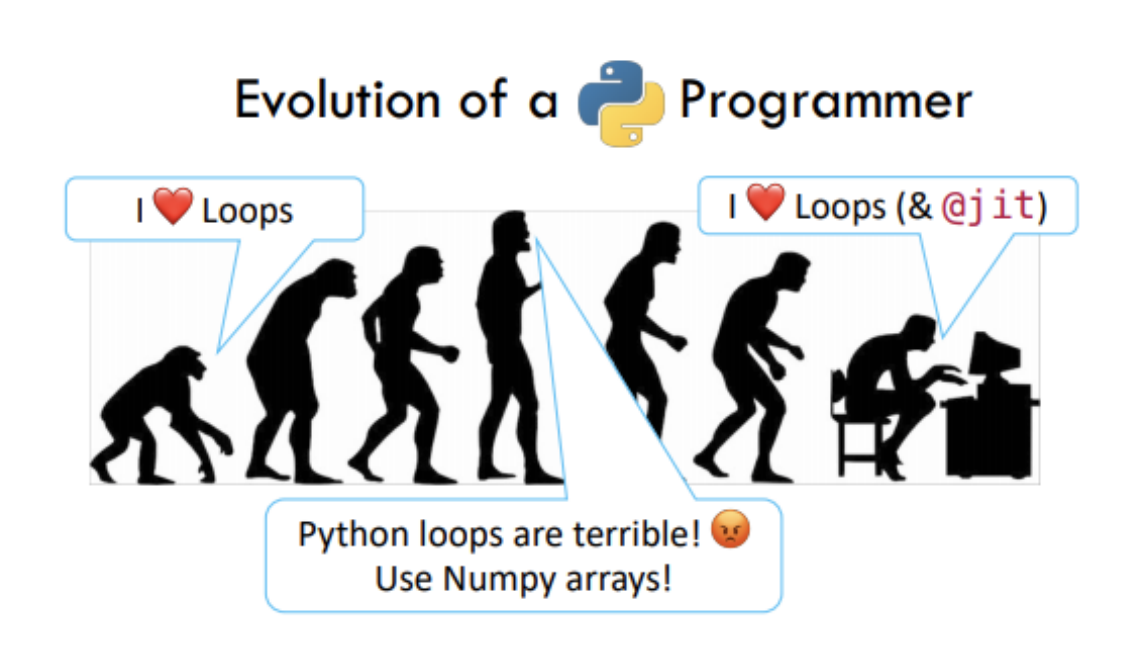

Внимательный читатель заметит, что функцию `wald_test_p_value` пришлось компилировать отдельно. Это одна из неприятных особенностей `numba`: рекурсивная компиляция не поддерживается, нужно вручную прописывать декораторы каждый раз.

Компиляция функции может занимать продолжительное время. Чтобы это не происходило при каждом запуске программы, можно дополнительно указать директиву `cache=True`, которая сохранит закэширует код на диске. Это уместно, когда при запуске программы `jit`-компилируется не одна простая функция, а целая библиотека.

## `@numba.vectorize`

По функционалу этот декоратор аналогичен функции `numpy.vectorize`, но результат оказывается лучше, т.к. он скомпилирован, а обработка входных данных автоматически распараллеливается. `@numba.vectorize` можно применять только к функциям, которые принимают и возвращают скаляры. Разве что сигнатуру функции при этом нужно прописывать явно ([список поддерживаемых типов](https://numba.pydata.org/numba-doc/dev/reference/types.html)).


Его работу иллюстрирует параллельное вычисление плотности нормального распределения в `n` точках выборки.  
Такая задача возникает при обучении метода опорных векторов (`SVM`) на больших выборках при использовании радиального ядра 
$$K(x, x') := \exp\left( - \frac{\|x -x'\|}{2\sigma^2} \right)$$

In [18]:
@numba.vectorize("float64(float64, float64, float64)", 
                 nopython=True, target="parallel")
def normal_pdf_numba_vectorize(x, mu, sigma):
    normalizing_constant = 1 / (sigma * math.sqrt(2 * math.pi))
    power = (x - mu) ** 2 / (2 * sigma**2)
    return normalizing_constant * math.exp(power)

Для наглядности, векторизованный метод сравнивается с функцией `scipy.norm.pdf`.

In [19]:
normal_rv = sps.norm()
sample_size = int(1e7)
sample = normal_rv.rvs(size=sample_size)

print("scipy.stats")
%timeit normal_rv.pdf(sample)
print("@numba.vectorize(nopython=True, target='parallel')")
%timeit normal_pdf_numba_vectorize(sample, 0, 1)

scipy.stats
1 loop, best of 3: 618 ms per loop
@numba.vectorize(nopython=True, target='parallel')
10 loops, best of 3: 182 ms per loop


Казалось бы, `scipy` — обкатанная в боях библиотека с множеством низкоуровневых оптимизаций.  
Тем не менее, `@numba.vectorize` работает примерно в 20 раз быстрее за счёт распараллеливания обработки точек.

# Joblib: распараллеливание и мемоизация 


В тех случаях, когда использовать `numba` не получается, а распараллелить код нужно, можно воспользоваться пакетом `joblib`.  
`joblib` также поддерживает эффективную мемоизацию (кэширование результатов вычисления функции).

## `joblib.Parallel`, `joblib.delayed`

Распараллеливание кода с помощью `joblib` происходит за счёт вызова функций `Parallel` и `delayed`.  
`Parallel` создаёт пул процессов, а `delayed` позволяет передать ему функцию. `joblib` накладывает ограничение, что и аргументы функции, и её возвращаемое значение должны быть сериализуемы. Напомним, что сериализация в случае `pickle` означает преобразование объекта в набор низкоуровневых инструкций для некоторой виртуальной машины (т.н. байт-код), которая потом по ним может восстановить объект. Подробнее о том, что можно сериализовать, а что нет, можно прочитать в [официальной документации](https://docs.python.org/3.4/library/pickle.html#what-can-be-pickled-and-unpickled). Это необходимо для того, чтобы преобразовать функцию вместе с содержимым в меньший по размерам поток байтов, который потом передаётся процессам-исполнителям. Чаще всего оно выполнено. Т.е. `joblib` может распараллелить не только всё то же, что и `numba`, но и многое другое.

Для иллюстрации использован пример векторизованной медианы средних Уолша, но в этот раз выборок мало, зато все они большого размера. Это принципиальный момент: создание процесса это тяжёлая операция, которая, по сути, создаёт копию текущего окружения. Если функция на каждом конкретном аргументе вычисляется быстро, то затраты на создание процессов и пересылку аргументов и возвращаемых значений между процессами перевесят выгоду от распараллеливания кода.

In [20]:
import joblib

matrix = np.random.randint(0, 100, (500, 500))

def square_row(row):
    for i in range(len(row)):
        row[i] *= row[i]
    return row

In [21]:
matrix.shape

(500, 500)

In [22]:
%%time
new_matrix = []
for row in matrix:
    new_matrix.append(square_row(row))
new_matrix = np.vstack(new_matrix)

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 116 ms


In [23]:
%%time
results = joblib.Parallel(n_jobs=2)(
    joblib.delayed(square_row)(row)
    for row in matrix
)
new_matrix = np.vstack(results)

CPU times: user 173 ms, sys: 57.1 ms, total: 230 ms
Wall time: 944 ms


Пример.

В Joblib можно кэшировать какую-либо дорогостоящую в плане вычислительных затрат функцию, выолняемую во время параллельного запуска. Функция **costly_compute** эмулирует эту трудоемкую функцию.

In [24]:
import time


def costly_compute(data, column):
    """Эмулирует тяжелую функцию при помощи sleep(), ф-ция возвращает столбец"""
    time.sleep(2)
    return data[column]


def data_processing_mean(data, column):
    """Считает среднее значение в столбце"""
    return costly_compute(data, column).mean()

In [25]:
import numpy as np
rng = np.random.RandomState(42)
data = rng.randn(int(1e4), 4)
print(data)
print('shape:', data.shape)

[[ 0.49671415 -0.1382643   0.64768854  1.52302986]
 [-0.23415337 -0.23413696  1.57921282  0.76743473]
 [-0.46947439  0.54256004 -0.46341769 -0.46572975]
 ...
 [ 2.71049244  0.77279139  1.82925283  0.99348728]
 [ 0.15851616 -0.59765756 -0.97683992  1.11965102]
 [ 0.26503405  0.61650104  0.8146235   0.35597439]]
shape: (10000, 4)


In [26]:
start = time.time()
results = [data_processing_mean(data, col) for col in range(data.shape[1])]
stop = time.time()

print('\n Последовательное выполнение (Sequential processing)')
print('Затраченное время: {:.2f} s'
      .format(stop - start))


 Последовательное выполнение (Sequential processing)
Затраченное время: 8.01 s


## `joblib.Memory`

`joblib` предоставляет механизм для кэширования результатов вычисления функций.
Это очень удобно, когда запусков планируется мало, но каждый запуск занимает значительное время (скажем, несколько часов) и нет уверенности, что программа не упадёт с ошибкой, так и не досчитав.  

В такой ситуации было бы очень уместно сохранить результаты промежуточных вычислений, чтобы потом просто загрузить их из памяти и начать с того же места, на котором исполнение прервалось.

Эту логику реализует класс `joblib.Memory`. Достаточно только указать папку, в которой будут хранится результаты, а остальное — проверку аргументов на соответствие, сохранение и подгрузку результатов из кэша — он сделает сам.

In [27]:
def data_processing_mean_using_cache(data, column):
    """Считает среднее значение в столбце"""
    return costly_compute_cached(data, column).mean()

In [28]:
from joblib import Memory

location = './cachedir' # определим директорию куда будем сохранять кэшированную функцию
memory = Memory(location, verbose=0)
costly_compute_cached = memory.cache(costly_compute)

In [29]:
from joblib import Parallel, delayed

start = time.time()
results = Parallel(n_jobs=2)(
    delayed(data_processing_mean_using_cache)(data, col)
    for col in range(data.shape[1]))
stop = time.time()

print('\nПервый проход - кэширование')
print('Затраченное время: {:.2f} s'
      .format(stop - start))


Первый проход - кэширование
Затраченное время: 4.05 s


In [30]:
start = time.time()
results = Parallel(n_jobs=2)(
    delayed(data_processing_mean_using_cache)(data, col)
    for col in range(data.shape[1]))
stop = time.time()

print('\nВторой проход - загружаем наш кэш')
print('Затраченное время: {:.2f} s'
      .format(stop - start))


Второй проход - загружаем наш кэш
Затраченное время: 0.03 s
